In [1]:
# Real + Imaginary together as one feature
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC


# Load dataset
measurement = np.load('../../../dataset/meas_symm_1.npz', allow_pickle=False)
header, data = measurement['header'], measurement['data']
data_cir = data['cirs'][:200]
n_comp = 6

# Train-test split
trainCIR, testCIR = train_test_split(data_cir, test_size=0.2, random_state=42)
print(f'trainData - {trainCIR.shape}')
print(f'testData - {testCIR.shape}')

# Define channels
alice_channel = 3  # A -> B (legitimate)
eve_channel = 6  # E -> B (illegitimate)

trainData - (160, 15, 251, 2)
testData - (40, 15, 251, 2)


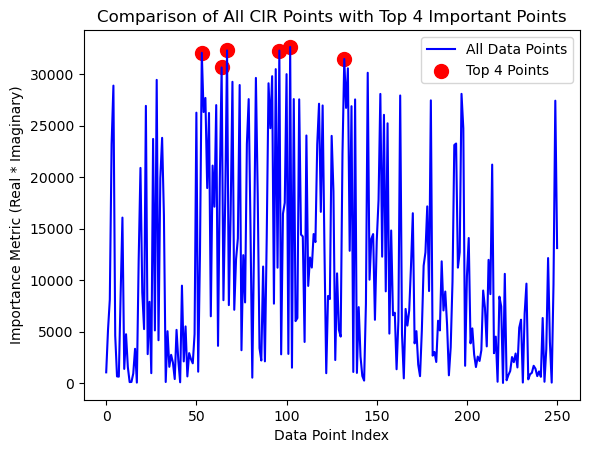

train_cirs_pca - (1, 6, 2)
train_labels - (320,)


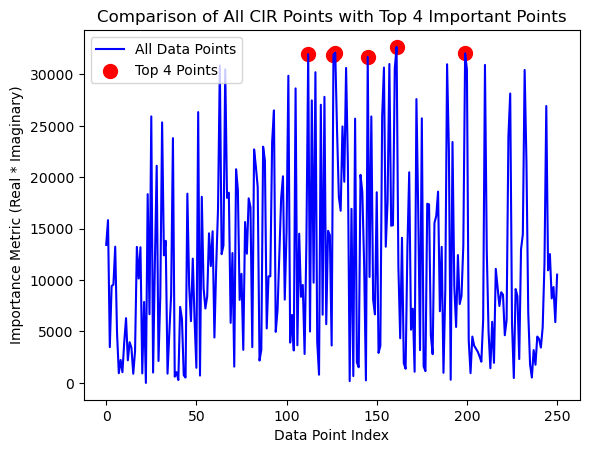

test_cirs_pca - (1, 6, 2)


In [ ]:
# -------------------------------------------------- Preprocessing ------------------------------------------
import matplotlib.pyplot as plt

def reduce_data_dimension(data, n_components):
    # data: (samples, 251, 2)
    
    reformed_cirs = []    
    for idx, cir in enumerate(data):
        if idx == 1:
            break
        
        products = np.abs(cir[:, 0] * cir[:, 1])
        # products = [12, 5, 0, 6, 12]

        # np.argsort(products) = [2, 1, 3, 0, 4]
        # np.argsort(products)[::-1] = [4, 0, 3, 1, 2] index in reverse order
        top_indices = np.argsort(products)[::-1][:n_components]
        top_components = cir[top_indices]
        reformed_cirs.append(top_components)
        
        # draw CIR ------------
        # # Plot the entire CIR (251 data points)
        # plt.plot(range(251), products, label='All Data Points', color='blue')
        # # Highlight the 4 most important data points
        # plt.scatter(top_indices, products[top_indices], color='red', label='Top 4 Points', s=100)
        
        # # Labeling the plot
        # plt.xlabel('Data Point Index')
        # plt.ylabel('Importance Metric (Real * Imaginary)')
        # plt.title('Comparison of All CIR Points with Top 4 Important Points')
        # plt.legend()
        # plt.show()

    reformed_cirs = np.array(reformed_cirs)
    
    return reformed_cirs

# -------- Train --------
# Feature Extraction
train_alice_cirs = trainCIR[:, alice_channel, :, :]  # (6400, 251, 2)
train_eve_cirs = trainCIR[:, eve_channel, :, :]      # (6400, 251, 2)
train_cirs = np.vstack((train_alice_cirs, train_eve_cirs))  # (12800, 251, 2)

# Dimension Redzuction
train_cirs_reduced = reduce_data_dimension(train_cirs, n_components=n_comp)  # (12800, n_components)
# Flatten for Classifier
train_cirs_flattened = train_cirs_reduced.reshape(train_cirs_reduced.shape[0], -1)  # (12800, 8)
print(f'train_cirs_pca - {train_cirs_reduced.shape}')

# Labels
train_alice_labels = np.zeros(train_alice_cirs.shape[0])  # '0' for Alice
train_eve_labels = np.ones(train_eve_cirs.shape[0])       # '1' for Eve
train_labels = np.hstack((train_alice_labels, train_eve_labels))  # (12800,)
print(f'train_labels - {train_labels.shape}')

# -------- Test --------
# Feature Extraction
test_alice_cirs = testCIR[:, alice_channel, :, :]  # (1600, 251, 2)
test_eve_cirs = testCIR[:, eve_channel, :, :]      # (1600, 251, 2)
test_cirs = np.vstack((test_alice_cirs, test_eve_cirs))  # (3200, 251, 2)
test_cirs_reduced = reduce_data_dimension(test_cirs, n_components=n_comp)  # (12800, n_components)
# Flatten for Classifier
test_cirs_flattened = test_cirs_reduced.reshape(test_cirs_reduced.shape[0], -1)  # (3200, 8)
print(f'test_cirs_pca - {test_cirs_reduced.shape}')

# Labels
test_alice_label = np.zeros(test_alice_cirs.shape[0])  # '0' for Alice
test_eve_labels = np.ones(test_eve_cirs.shape[0])       # '1' for Eve
test_labels = np.hstack((test_alice_label, test_eve_labels))  # (3200,)

In [3]:
# ----------------- Classification -----------------
# Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_cirs_flattened, train_labels)

# Predict on test data
predictions = knn.predict(test_cirs_flattened)


ValueError: Found input variables with inconsistent numbers of samples: [1, 320]

In [ ]:
# # Initialize and train the SVM classifier
# classifier = SVC(kernel='linear', random_state=42)
# classifier.fit(train_cirs_flattened, train_labels)

# # Predict on test data
# predictions = classifier.predict(test_cirs_flattened)

In [ ]:
# ----------------- Evaluation -----------------
# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, predictions, labels=[0, 1]).ravel()

print(f"tp: {tp}")
print(f"tn: {tn}")
print(f"fp: {fp}")
print(f"fn: {fn}")

# Missed Detection Rate (MDR)
MDR = fp / (fp + tn) if (fp + tn) > 0 else 0

# False Alarm Rate (FAR)
FAR = fn / (fn + tp) if (fn + tp) > 0 else 0

# Gamma calculation
gamma = (tp + fn) / (tn + fp) if (tn + fp) > 0 else 0

# Authentication Rate (AR)
denominator = (tp + fn) + gamma * (tn + fp)
AR = (tp + gamma * tn) / denominator if denominator > 0 else 0

print(f"MDR: {MDR}")
print(f"FAR: {FAR}")
print(f"AR: {AR}")

Classification Accuracy: 53.75%
tp: 20
tn: 23
fp: 17
fn: 20
MDR: 0.425
FAR: 0.5
AR: 0.5375


In [ ]:
cir = [
    [3, 4],   # Data point 1: real = 3, imaginary = 4
    [1, 5],   # Data point 2: real = 1, imaginary = 5
    [0, 2],   # Data point 3: real = 0, imaginary = 2
    [6, 1],   # Data point 4: real = 6, imaginary = 1
    [4, 3]    # Data point 5: real = 4, imaginary = 3
]
